1. Load breast cancer dataset (**structured data**)

For more details about the data: https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_breast_cancer.html

In [5]:

from sklearn.datasets import load_breast_cancer

my_data = load_breast_cancer()


2. Visualize the data

- Only **5 points** for visualizing the data
- Use TSNE algorithm: sklearn.manifold.TSNE
- A good and simple code can be found here (they used PCA instead of TSNE): https://skp2707.medium.com/pca-on-cancer-dataset-4d7a97f5fdb8

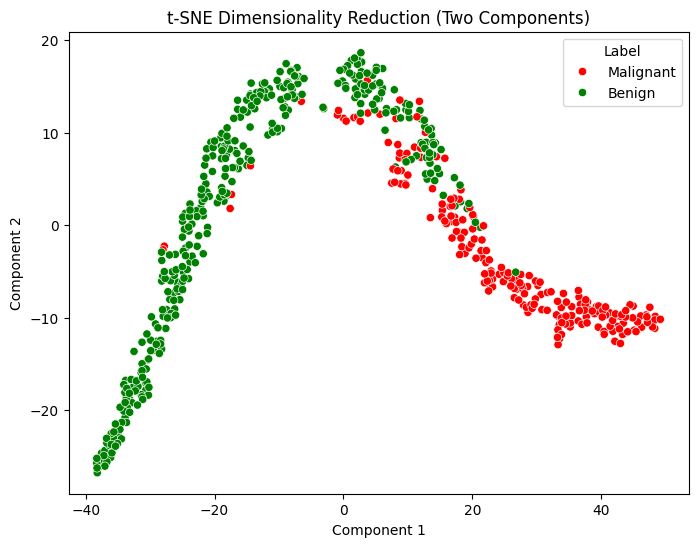

In [14]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Using raw data directly (without normalization)
raw_data = my_data.data

# Dimensionality reduction with t-SNE to two components
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_data = tsne.fit_transform(raw_data)

# Create a DataFrame with the transformed data and labels
tsne_df = pd.DataFrame(np.vstack((tsne_data.T, my_data.target)).T,
                       columns=['Component 1', 'Component 2', 'Label'])

# Replace numeric labels with descriptive ones
tsne_df['Label'] = tsne_df['Label'].replace(0.0, 'Malignant')
tsne_df['Label'] = tsne_df['Label'].replace(1.0, 'Benign')

# Visualization of the data
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='Component 1', y='Component 2', hue='Label', palette={'Malignant': 'red', 'Benign': 'green'})
plt.title('t-SNE Dimensionality Reduction (Two Components)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Label')
plt.show()


3. Split **my_data** to train and test:

- Define X_train, X_test, Y_train, Y_test
- Choose **test_size** for splitting **my_data**
- Use **train_test_split** (for details: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html)

In [7]:

from sklearn.model_selection import train_test_split

# Define the features and target variables
X = my_data.data  # Features
Y = my_data.target  # Labels

# Set the test set size (20% of the total dataset, for example)
test_size = 0.2

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

# Print the sizes of the training and testing sets
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature count: {X_train.shape[1]}")

Train set size: 455 samples
Test set size: 114 samples
Feature count: 30


4. Train **model_decision_tree**

- Library: sklearn.tree.DecisionTreeClassifier
- Data: X_train, Y_train
- **Essential**: explore and optimize DecisionTreeClassifier options   

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Initialize the DecisionTreeClassifier model
model_decision_tree = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
model_decision_tree.fit(X_train, Y_train)

# Define the parameter grid for search
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criterion for splitting
    'max_depth': [3, 5, 10, None],      # Tree depth
    'min_samples_split': [2, 5, 10],    # Minimum samples for a split
    'min_samples_leaf': [1, 2, 4]       # Minimum samples for a leaf
}

# Define F1 score as the scoring metric
scorer = make_scorer(f1_score)

# Perform GridSearchCV for optimal parameters
grid_search = GridSearchCV(estimator=model_decision_tree, param_grid=param_grid, scoring=scorer, cv=3)
grid_search.fit(X_train, Y_train)

# Print the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

# Train the model with the best parameters
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, Y_train)

# Predict results on the test set
Y_pred = best_model.predict(X_test)

# Evaluate the model with various metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Print the grid search results for each parameter combination
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Params: {results['params'][i]} | Mean F1: {results['mean_test_score'][i]:.3f}")


Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best F1 Score: 0.951695218361885
Accuracy: 0.9649122807017544
Precision: 0.9466666666666667
Recall: 1.0
F1 Score: 0.9726027397260274
Confusion Matrix:
[[39  4]
 [ 0 71]]
Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2} | Mean F1: 0.936
Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5} | Mean F1: 0.936
Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10} | Mean F1: 0.938
Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2} | Mean F1: 0.936
Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5} | Mean F1: 0.936
Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10} | Mean F1: 0.938
Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf

5. Train model_random_forest
- Library: sklearn.ensemble.RandomForestClassifier
- Data: X_train, Y_train
- **Essential**: explore and optimize RandomForestClassifier options

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Initialize the RandomForestClassifier model
model_random_forest = RandomForestClassifier(random_state=42)

# Train the model on the training data
model_random_forest.fit(X_train, Y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],    # Maximum depth of each tree
    'min_samples_split': [2, 5, 10], # Minimum samples for a split
    'min_samples_leaf': [1, 2, 4],   # Minimum samples for a leaf
    'criterion': ['gini', 'entropy'] # Splitting criterion
}

# Define F1 score as the scoring metric
scorer = make_scorer(f1_score)

# Perform GridSearchCV for optimal parameters
grid_search = GridSearchCV(estimator=model_random_forest, param_grid=param_grid, scoring=scorer, cv=3)
grid_search.fit(X_train, Y_train)

# Retrieve and print the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

# Train the model with the best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, Y_train)

# Predict results on the test set
Y_pred = best_model.predict(X_test)

# Evaluate the model with various metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Print the grid search results for each parameter combination
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Params: {results['params'][i]} | Mean F1: {results['mean_test_score'][i]:.3f}")


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 Score: 0.97225566906505
Accuracy: 0.9649122807017544
Precision: 0.958904109589041
Recall: 0.9859154929577465
F1 Score: 0.9722222222222222
Confusion Matrix:
[[40  3]
 [ 1 70]]
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} | Mean F1: 0.965
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} | Mean F1: 0.964
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} | Mean F1: 0.960
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50} | Mean F1: 0.967
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} | Mean F1: 0.965
Params: {'criterion': 'gini', 'ma

6. Train model_adaboost

- Library: sklearn.ensemble.AdaBoostClassifier
- Data: X_train, Y_train
- **Essential**: explore and optimize AdaBoostClassifier options

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier  # Base estimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Initialize the AdaBoostClassifier model
model_adaboost = AdaBoostClassifier(random_state=42)

# Train the model on the training data
model_adaboost.fit(X_train, Y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.1, 1.0],  # Weight of each classifier
    'algorithm': ['SAMME', 'SAMME.R'],  # Boosting algorithm (SAMME or SAMME.R)
}

# Define F1 score as the scoring metric
scorer = make_scorer(f1_score)

# Perform GridSearchCV for optimal parameters
grid_search = GridSearchCV(estimator=model_adaboost, param_grid=param_grid, scoring=scorer, cv=3)
grid_search.fit(X_train, Y_train)

# Retrieve and print the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

# Train the model with the best parameters
best_model = AdaBoostClassifier(n_estimators=best_params['n_estimators'],
                                learning_rate=best_params['learning_rate'],
                                algorithm=best_params['algorithm'],
                                random_state=42)
best_model.fit(X_train, Y_train)

# Predict results on the test set
Y_pred = best_model.predict(X_test)

# Evaluate the model with various metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Print the grid search results for each parameter combination
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Params: {results['params'][i]} | Mean F1: {results['mean_test_score'][i]:.3f}")



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100}
Best F1 Score: 0.9795020989862327
Accuracy: 0.9736842105263158
Precision: 0.9722222222222222
Recall: 0.9859154929577465
F1 Score: 0.9790209790209791
Confusion Matrix:
[[41  2]
 [ 1 70]]
Params: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 50} | Mean F1: 0.941
Params: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 100} | Mean F1: 0.937
Params: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 200} | Mean F1: 0.950
Params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50} | Mean F1: 0.964
Params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100} | Mean F1: 0.967
Params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200} | Mean F1: 0.967
Params: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 50} | Mean F1: 0.978
Params: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100} | Mean F1: 0.980
Par

7. Evaluate model_decision_tree, model_random_forest, model_adaboost

- Library: sklearn.metrics
- Data: X_test, Y_test
- **Calculate** and **print** results of each classifier
- **Choose** the decisive metric
- **Compare** between the classifiers and declare the winner


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# List of models for evaluation
models = {
    'model_decision Tree': model_decision_tree,
    'model_random Forest': model_random_forest,
    'model_adaBoost': model_adaboost
}

# Variable to store the performance results of each classifier
results = {}

# Evaluation of each classifier
for model_name, model in models.items():
    # Predicting the results on the test set
    Y_pred = model.predict(X_test)

    # Calculating the various metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, zero_division=1)  # zero_division=1 to avoid division by zero issues
    recall = recall_score(Y_test, Y_pred, zero_division=1)
    f1 = f1_score(Y_test, Y_pred, zero_division=1)
    conf_matrix = confusion_matrix(Y_test, Y_pred)

    # Saving the results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_matrix
    }

    # Displaying the model's results
    print(f"Results for {model_name}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1 Score: {f1:.3f}")
    print(f"  Confusion Matrix:\n{conf_matrix}")
    print("-" * 50)

# Choosing the decisive metric - here we select the F1 Score, but this can be changed as needed
decisive_metric = 'F1 Score'

# Finding the model with the highest score according to the decisive metric
best_model_name = max(results, key=lambda model: results[model][decisive_metric])

# Displaying the final comparison
print("\nSummary of model performance:")
for model_name, metrics in results.items():
    print(f"{model_name} - {decisive_metric}: {metrics[decisive_metric]:.3f}")

print(f"\nThe best model according to {decisive_metric} is: {best_model_name}!")


Results for model_decision Tree:
  Accuracy: 0.947
  Precision: 0.958
  Recall: 0.958
  F1 Score: 0.958
  Confusion Matrix:
[[40  3]
 [ 3 68]]
--------------------------------------------------
Results for model_random Forest:
  Accuracy: 0.965
  Precision: 0.959
  Recall: 0.986
  F1 Score: 0.972
  Confusion Matrix:
[[40  3]
 [ 1 70]]
--------------------------------------------------
Results for model_adaBoost:
  Accuracy: 0.974
  Precision: 0.972
  Recall: 0.986
  F1 Score: 0.979
  Confusion Matrix:
[[41  2]
 [ 1 70]]
--------------------------------------------------

Summary of model performance:
model_decision Tree - F1 Score: 0.958
model_random Forest - F1 Score: 0.972
model_adaBoost - F1 Score: 0.979

The best model according to F1 Score is: model_adaBoost!
